## Final Project Submission

Please fill out:
* Student name: Qilun Chen, 
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [512]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

# Data cleaning

In [380]:
data = pd.read_csv('data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [381]:
data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [506]:
data.dtypes

id                             int64
date                  datetime64[ns]
price                        float64
bedrooms                       int64
bathrooms                    float64
sqft_living                    int64
sqft_lot                       int64
floors                       float64
waterfront                    object
view                          object
condition                     object
grade                         object
sqft_above                     int64
sqft_basement                float64
yr_built                       int64
yr_renovated                 float64
zipcode                        int64
sqft_living15                  int64
sqft_lot15                     int64
propertyTaxPerYear           float64
livingAreaRatio              float64
year_sold                      int64
houseAge                       int64
pricePerSqft                 float64
dtype: object

In [509]:
data.loc[:, 'sqft_basement'] = data['sqft_basement'].str.replace("?","0.0")
data.loc[:, 'sqft_basement'] = data['sqft_basement'].astype('float64')

AttributeError: Can only use .str accessor with string values!

In [384]:
data['view'].head()

0    NONE
1    NONE
2    NONE
3    NONE
4    NONE
Name: view, dtype: object

In [385]:
data['waterfront'].head()

0    NaN
1     NO
2     NO
3     NO
4     NO
Name: waterfront, dtype: object

In [386]:
data['yr_renovated'].head()

0       0.0
1    1991.0
2       NaN
3       0.0
4       0.0
Name: yr_renovated, dtype: float64

In [387]:
data['view'] = data['view'].fillna('NONE')

In [388]:
data['waterfront'] = data['waterfront'].fillna('NO')

In [389]:
data['yr_renovated'] = data['yr_renovated'].fillna(0)

In [510]:
data.isna().sum().sum()

0

In [391]:
data['zipcode'].value_counts().head()

98103    602
98038    589
98115    583
98052    574
98117    553
Name: zipcode, dtype: int64

In [392]:
data[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']].head()

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,1180,5650,1180,0.0,1340,5650
1,2570,7242,2170,400.0,1690,7639
2,770,10000,770,0.0,2720,8062
3,1960,5000,1050,910.0,1360,5000
4,1680,8080,1680,0.0,1800,7503


In [393]:
data['floors'].value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [394]:
data.drop(columns = 'lat', inplace = True)

In [395]:
data.drop(columns = 'long', inplace = True)

In [396]:
data['propertyTaxPerYear'] = data['price'] * 0.0101

In [397]:
data['livingAreaRatio'] = data['sqft_living'] / data['sqft_lot']

In [398]:
data['date'] = pd.to_datetime(data['date'])
data['year_sold'] = data['date'].dt.year

In [430]:
data['houseAge'] = data['year_sold'] - data['yr_built']

In [402]:
data['pricePerSqft'] = data['price'] / data['sqft_lot']

# If you are builders

## Linear Regression

### looking for great land lot rebuild to mixed-use house

find high demand zip code. find big lot with small house in the area. find house house 

In [237]:
data['zipcode'].value_counts().head(9)

98103    602
98038    589
98115    583
98052    574
98117    553
98042    547
98034    545
98118    507
98023    499
Name: zipcode, dtype: int64

In [238]:
data.corr()['pricePerSqft']

id                    0.059813
price                 0.308066
bedrooms             -0.062884
bathrooms             0.202578
sqft_living           0.022404
sqft_lot             -0.206256
floors                0.477914
sqft_above           -0.004770
yr_built              0.124420
yr_renovated          0.034789
zipcode               0.221420
sqft_living15        -0.044397
sqft_lot15           -0.228634
propertyTaxPerYear    0.308066
livingAreaRatio       0.896127
houseAge             -0.124420
pricePerSqft          1.000000
year_sold             0.010053
Name: pricePerSqft, dtype: float64

In [239]:
data.corr()['sqft_living']

id                   -0.012241
price                 0.701917
bedrooms              0.578212
bathrooms             0.755758
sqft_living           1.000000
sqft_lot              0.173453
floors                0.353953
sqft_above            0.876448
yr_built              0.318152
yr_renovated          0.051060
zipcode              -0.199802
sqft_living15         0.756402
sqft_lot15            0.184342
propertyTaxPerYear    0.701917
livingAreaRatio       0.076988
houseAge             -0.318152
pricePerSqft          0.022404
year_sold            -0.029014
Name: sqft_living, dtype: float64

In [240]:
simple_formula = 'pricePerSqft~price'
simple_model = ols(simple_formula, data).fit()
simple_model_summary = simple_model.summary()
simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           pricePerSqft   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     2264.
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:48:53   Log-Likelihood:            -1.2770e+05
No. Observations:               21597   AIC:                         2.554e+05
Df Residuals:                   21595   BIC:                         2.554e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.3725      1.083     42.819      0.000      44.250      48.495
price       7.888e-05   1.66e-06     47.585      0.000    7.56e-05    8.21e-05
==============================================================================
Omnibus:                    16212.990   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           489434.062
Skew:                           3.325   Prob(JB):                         0.00
Kurtosis:                      25.354   Cond. No.                     1.16e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [241]:
multiple_formula = 'pricePerSqft~price+livingAreaRatio'
multiple_model = ols(multiple_formula, data).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           pricePerSqft   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 5.787e+04
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:48:53   Log-Likelihood:            -1.0880e+05
No. Observations:               21597   AIC:                         2.176e+05
Df Residuals:                   21594   BIC:                         2.176e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -37.6399      0.522    -72.108      0.000     -38.663     -36.617
price            5.142e-05   6.96e-07     73.858      0.000    5.01e-05    5.28e-05
livingAreaRatio   305.3147      0.953    320.480      0.000     303.447     307.182
==============================================================================
Omnibus:                    10329.168   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           334462.306
Skew:                           1.680   Prob(JB):                         0.00
Kurtosis:                      21.984   Cond. No.                     2.57e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [242]:
data['livingAreaRatio'].mean()

0.32375545559503777

In [243]:
df = data[['price','sqft_living', 'sqft_lot', 'floors', 'sqft_above','livingAreaRatio','houseAge','pricePerSqft','zipcode']]
df

,price,sqft_living,sqft_lot,floors,sqft_above,livingAreaRatio,houseAge,pricePerSqft,zipcode
0,221900.0,1180,5650,1.0,1180,0.208850,67,39.274336,98178
1,538000.0,2570,7242,2.0,2170,0.354874,71,74.288870,98125
2,180000.0,770,10000,1.0,770,0.077000,89,18.000000,98028
3,604000.0,1960,5000,1.0,1050,0.392000,57,120.800000,98136
4,510000.0,1680,8080,1.0,1680,0.207921,35,63.118812,98074
...,...,...,...,...,...,...,...,...,...
21592,360000.0,1530,1131,3.0,1530,1.352785,13,318.302387,98103
21593,400000.0,2310,5813,2.0,2310,0.397385,8,68.811285,98146
21594,402101.0,1020,1350,2.0,1020,0.755556,13,297.852593,98144
21595,400000.0,1600,2388,2.0,1600,0.670017,18,167.504188,98027


In [244]:
zipcode_df = df.groupby(by = ["zipcode"]).mean()

In [245]:
zipcode_df.sort_values(by = ['pricePerSqft'], ascending = False).head()

,price,sqft_living,sqft_lot,floors,sqft_above,livingAreaRatio,houseAge,pricePerSqft
zipcode,,,,,,,,
98102,8.996077e+05,2151.048077,3605.153846,1.990385,1752.442308,0.777736,69.836538,322.561090
98119,8.497148e+05,2005.614130,3615.217391,1.793478,1589.961957,0.692205,74.380435,287.432530
98109,8.800778e+05,2054.779817,3621.082569,1.729358,1637.348624,0.671971,77.972477,281.081375
98112,1.096239e+06,2498.743494,4990.431227,1.806691,2005.695167,0.621954,77.550186,261.968320
98107,5.791098e+05,1579.548872,3194.368421,1.834586,1317.218045,0.660090,62.368421,243.382314


### focus on 98102

In [246]:
df_98102 = data[data['zipcode'] == 98102]

In [247]:
df_98102.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,propertyTaxPerYear,livingAreaRatio,houseAge,pricePerSqft,year_sold
count,1.040000e+02,1.040000e+02,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.0,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,4.102040e+09,8.996077e+05,3.250000,2.283654,2151.048077,3605.153846,1.990385,1752.442308,1952.163462,76.576923,98102.0,1954.471154,3303.500000,9086.037498,0.777736,69.836538,322.561090,2014.259615
std,2.636774e+09,7.903814e+05,1.146967,0.936100,1416.956148,3738.541805,0.535084,1034.478508,43.927591,384.748000,0.0,592.328447,1875.940893,7982.851802,0.360766,43.927591,160.708592,0.440547
min,9.520067e+08,3.300000e+05,2.000000,1.000000,710.000000,857.000000,1.000000,710.000000,1900.000000,0.000000,98102.0,1120.000000,1079.000000,3333.000000,0.156333,8.000000,64.257231,2014.000000
25%,1.965075e+09,5.718750e+05,3.000000,1.750000,1370.000000,1339.250000,2.000000,1171.000000,1910.000000,0.000000,98102.0,1515.000000,1438.750000,5775.937500,0.501136,17.000000,185.116700,2014.000000
50%,2.902200e+09,7.100000e+05,3.000000,2.250000,1780.000000,3085.500000,2.000000,1585.000000,1926.500000,0.000000,98102.0,1810.000000,3210.000000,7171.000000,0.667841,95.500000,286.857143,2014.000000
75%,6.762700e+09,9.761750e+05,4.000000,2.750000,2480.000000,4400.000000,2.000000,2070.000000,2005.000000,0.000000,98102.0,2230.000000,4500.000000,9859.367500,1.082727,112.000000,418.141206,2015.000000
max,9.831201e+09,7.700000e+06,9.000000,8.000000,12050.000000,27600.000000,3.000000,8570.000000,2014.000000,2014.000000,98102.0,3940.000000,11500.000000,77770.000000,1.738623,122.000000,738.833333,2015.000000


I am going to be to develop a pricing algorithm to help set a target price for new house that are released to market. The goal is to tell the customer new price and to help ensure consistency in pricing between new products and past products.

In [265]:
x_train_98102 = df_98102


x_train_98102 = x_train_98102.drop(["price","pricePerSqft","propertyTaxPerYear"],axis = 1)
y_train_98102 = df_98102["price"]

x_train_98102

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,livingAreaRatio,houseAge,year_sold
100,1952200240,2014-06-11,3,2.50,2070,13241,1.5,NO,NONE,Very Good,...,1270,800.0,1910,0.0,98102,2200,4500,0.156333,112,2014
327,1959700550,2014-09-05,4,2.00,2050,4400,1.5,NO,NONE,Good,...,2050,0.0,1922,0.0,98102,2320,5500,0.465909,100,2014
673,1959701890,2014-07-29,4,1.75,1800,4180,2.0,NO,GOOD,Good,...,1800,0.0,1921,0.0,98102,2180,4620,0.430622,101,2014
890,1962200435,2014-11-10,4,1.00,1820,5400,1.5,NO,NONE,Average,...,1820,?,1923,2014.0,98102,1820,5400,0.337037,99,2014
961,6852700478,2014-09-16,2,1.00,970,2970,1.0,NO,NONE,Average,...,970,0.0,1910,0.0,98102,1670,3000,0.326599,112,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20901,6762700452,2014-06-13,3,3.00,1384,1287,2.0,NO,NONE,Average,...,1144,240.0,2006,0.0,98102,1570,1288,1.075369,16,2014
20910,6852700097,2014-08-06,3,3.25,1610,1275,2.0,NO,NONE,Average,...,1220,390.0,2005,0.0,98102,1750,3000,1.262745,17,2014
21055,2163900081,2015-02-20,3,2.50,1990,1891,3.0,NO,NONE,Average,...,1990,0.0,2012,0.0,98102,1990,3600,1.052353,10,2015
21184,1959700225,2015-02-24,3,1.75,1370,1990,3.0,NO,NONE,Average,...,1370,0.0,2014,0.0,98102,1730,1990,0.688442,8,2015


In [266]:
x_train_98102.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 100 to 21567
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               104 non-null    int64         
 1   date             104 non-null    datetime64[ns]
 2   bedrooms         104 non-null    int64         
 3   bathrooms        104 non-null    float64       
 4   sqft_living      104 non-null    int64         
 5   sqft_lot         104 non-null    int64         
 6   floors           104 non-null    float64       
 7   waterfront       104 non-null    object        
 8   view             104 non-null    object        
 9   condition        104 non-null    object        
 10  grade            104 non-null    object        
 11  sqft_above       104 non-null    int64         
 12  sqft_basement    104 non-null    object        
 13  yr_built         104 non-null    int64         
 14  yr_renovated     104 non-null    float

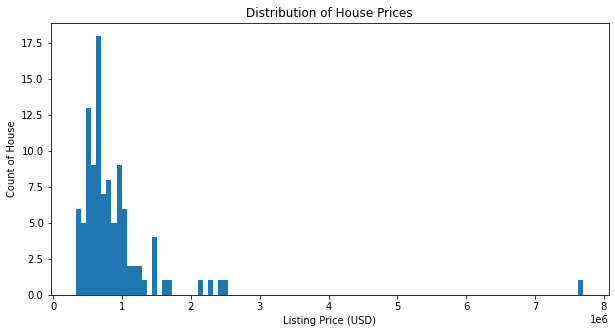

In [267]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(y_train_98102, bins=100)

ax.set_xlabel("Listing Price (USD)")
ax.set_ylabel("Count of House")
ax.set_title("Distribution of House Prices");

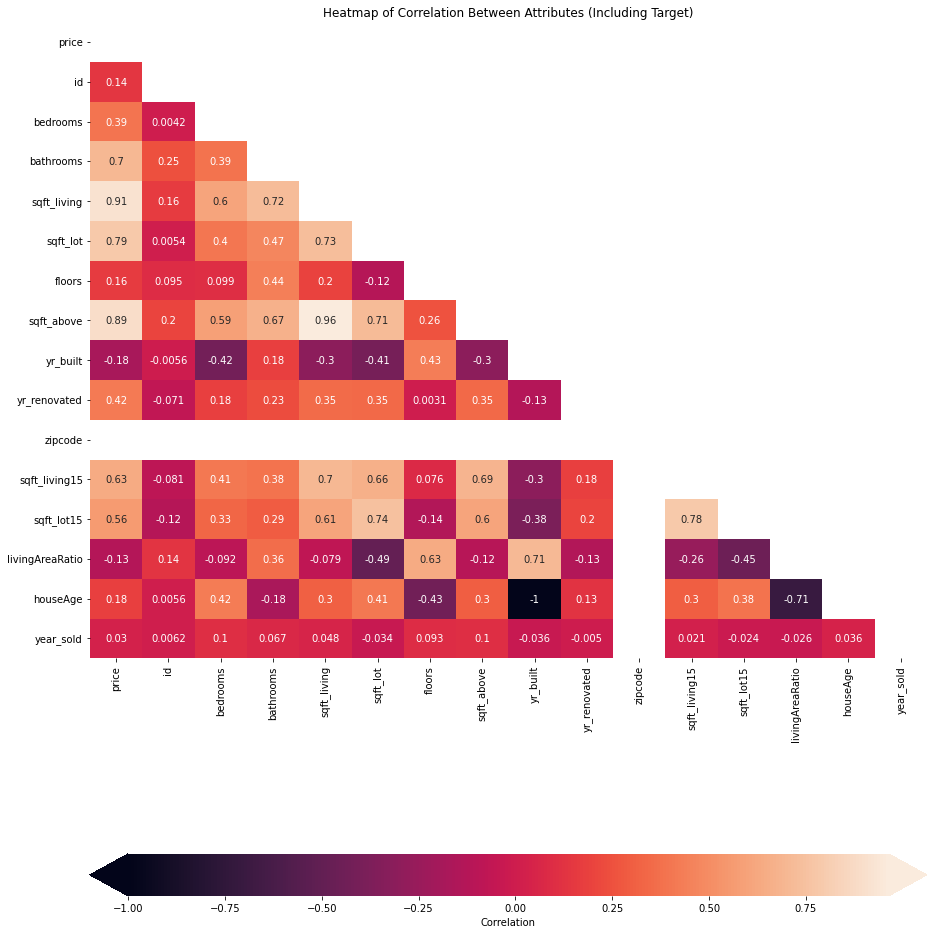

In [268]:
heatmap_data = pd.concat([y_train_98102, x_train_98102], axis=1)
corr = heatmap_data.corr()

fig, ax = plt.subplots(figsize=(15, 18))

sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [269]:
most_correlated_feature = "sqft_living"

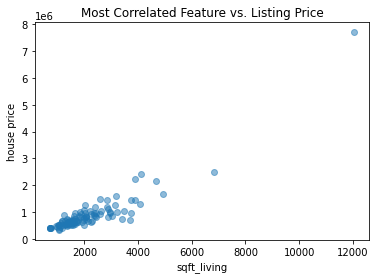

In [270]:
fig, ax = plt.subplots()

ax.scatter(x_train_98102[most_correlated_feature], y_train_98102, alpha=0.5)
ax.set_xlabel(most_correlated_feature)
ax.set_ylabel("house price")
ax.set_title("Most Correlated Feature vs. Listing Price");

In [271]:

baseline_model = LinearRegression()

In [272]:

from sklearn.model_selection import cross_validate, ShuffleSplit

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=x_train_98102[[most_correlated_feature]],
    y=y_train_98102,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.8571585347927156
Validation score: 0.30493302786183335


In [273]:

X_train_numeric = x_train_98102.select_dtypes("number").copy()

X_train_numeric

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,livingAreaRatio,houseAge,year_sold
100,1952200240,3,2.50,2070,13241,1.5,1270,1910,0.0,98102,2200,4500,0.156333,112,2014
327,1959700550,4,2.00,2050,4400,1.5,2050,1922,0.0,98102,2320,5500,0.465909,100,2014
673,1959701890,4,1.75,1800,4180,2.0,1800,1921,0.0,98102,2180,4620,0.430622,101,2014
890,1962200435,4,1.00,1820,5400,1.5,1820,1923,2014.0,98102,1820,5400,0.337037,99,2014
961,6852700478,2,1.00,970,2970,1.0,970,1910,0.0,98102,1670,3000,0.326599,112,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20901,6762700452,3,3.00,1384,1287,2.0,1144,2006,0.0,98102,1570,1288,1.075369,16,2014
20910,6852700097,3,3.25,1610,1275,2.0,1220,2005,0.0,98102,1750,3000,1.262745,17,2014
21055,2163900081,3,2.50,1990,1891,3.0,1990,2012,0.0,98102,1990,3600,1.052353,10,2015
21184,1959700225,3,1.75,1370,1990,3.0,1370,2014,0.0,98102,1730,1990,0.688442,8,2015


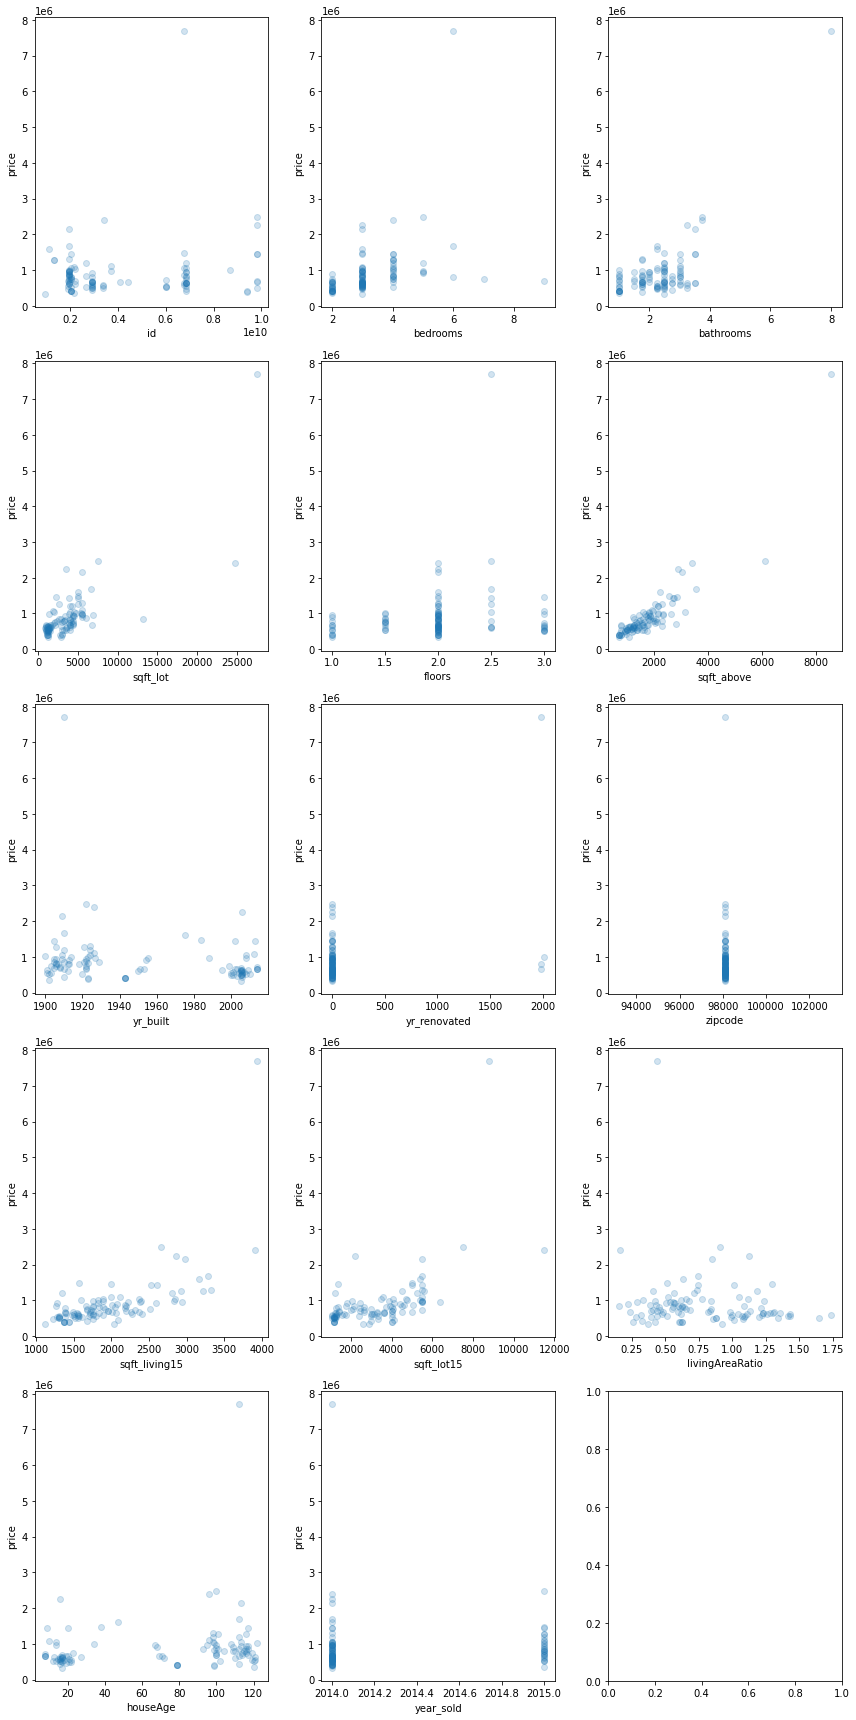

In [274]:

scatterplot_data = X_train_numeric.drop("sqft_living", axis=1)

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(12, 24))
fig.set_tight_layout(True)

for index, col in enumerate(scatterplot_data.columns):
    ax = axes[index//3][index%3]
    ax.scatter(X_train_numeric[col], y_train_98102, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("price")

In [275]:

X_train_second_model = X_train_numeric.drop(["id", "year_sold", "zipcode", "yr_renovated"], axis=1).copy()

X_train_second_model

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,livingAreaRatio,houseAge
100,3,2.50,2070,13241,1.5,1270,1910,2200,4500,0.156333,112
327,4,2.00,2050,4400,1.5,2050,1922,2320,5500,0.465909,100
673,4,1.75,1800,4180,2.0,1800,1921,2180,4620,0.430622,101
890,4,1.00,1820,5400,1.5,1820,1923,1820,5400,0.337037,99
961,2,1.00,970,2970,1.0,970,1910,1670,3000,0.326599,112
...,...,...,...,...,...,...,...,...,...,...,...
20901,3,3.00,1384,1287,2.0,1144,2006,1570,1288,1.075369,16
20910,3,3.25,1610,1275,2.0,1220,2005,1750,3000,1.262745,17
21055,3,2.50,1990,1891,3.0,1990,2012,1990,3600,1.052353,10
21184,3,1.75,1370,1990,3.0,1370,2014,1730,1990,0.688442,8


In [276]:

second_model = LinearRegression()

second_model_scores = cross_validate(
    estimator=second_model,
    X=X_train_second_model,
    y=y_train_98102,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.9382115679416976
Validation score: 0.5796555037998196

Baseline Model
Train score:      0.8571585347927156
Validation score: 0.30493302786183335


In [277]:
import statsmodels.api as sm

sm.OLS(y_train_98102, sm.add_constant(X_train_second_model)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     112.0
Date:                Tue, 29 Mar 2022   Prob (F-statistic):           2.37e-47
Time:                        16:04:04   Log-Likelihood:                -1425.9
No. Observations:                 104   AIC:                             2874.
Df Residuals:                      93   BIC:                             2903.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.1765      0.406     -2.897      0.005      -1.983      -0.370
bedrooms        -1.299e+05   2.72e+04     -4.781      0.000   -1.84e+05   -7.59e+04
bathrooms        3.546e+04   5.17e+04      0.686      0.495   -6.72e+04    1.38e+05
sqft_living       407.9780     81.996      4.976      0.000     245.149     570.807
sqft_lot           64.4595     13.671      4.715      0.000      37.312      91.607
floors          -2.003e+04   6.78e+04     -0.295      0.768   -1.55e+05    1.15e+05
sqft_above        144.4075     97.694      1.478      0.143     -49.594     338.409
yr_built          259.6963     87.321      2.974      0.004      86.295     433.098
sqft_living15      29.4655     71.129      0.414      0.680    -111.782     170.713
sqft_lot15        -79.1255     23.171     -3.415      0.001    -125.139     -33.112
livingAreaRatio -2.588e+05   1.52e+05     -1.705      0.092    -5.6e+05    4.26e+04
houseAge        -2638.6485    866.119     -3.047      0.003   -4358.590    -918.707
==============================================================================
Omnibus:                        6.945   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.031   Jarque-Bera (JB):               12.408
Skew:                           0.066   Prob(JB):                      0.00202
Kurtosis:                       4.687   Cond. No.                     2.16e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.21e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [278]:
significant_features = ["sqft_living", "sqft_living15"]

In [279]:
third_model = LinearRegression()
X_train_third_model = x_train_98102[significant_features]

third_model_scores = cross_validate(
    estimator=third_model,
    X=X_train_third_model,
    y=y_train_98102,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", third_model_scores["train_score"].mean())
print("Validation score:", third_model_scores["test_score"].mean())
print()
print("Second Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.8575898361852675
Validation score: 0.2880030679852374

Second Model
Train score:      0.9382115679416976
Validation score: 0.5796555037998196

Baseline Model
Train score:      0.8571585347927156
Validation score: 0.30493302786183335


In [280]:

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
X_train_for_RFECV = StandardScaler().fit_transform(X_train_second_model)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train_98102)

# Print the results
print("Was the column selected?")
for index, col in enumerate(X_train_second_model.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
bedrooms: True
bathrooms: True
sqft_living: True
sqft_lot: True
floors: False
sqft_above: True
yr_built: True
sqft_living15: False
sqft_lot15: True
livingAreaRatio: True
houseAge: True


# Hypothesis Testing

### renovated house has more value

In [258]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,propertyTaxPerYear,livingAreaRatio,houseAge,pricePerSqft,year_sold
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NO,NONE,...,1955,0.0,98178,1340,5650,2241.19,0.208850,67,39.274336,2014
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1951,1991.0,98125,1690,7639,5433.80,0.354874,71,74.288870,2014
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,1933,0.0,98028,2720,8062,1818.00,0.077000,89,18.000000,2015
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1965,0.0,98136,1360,5000,6100.40,0.392000,57,120.800000,2014
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1987,0.0,98074,1800,7503,5151.00,0.207921,35,63.118812,2015


In [259]:
data['yr_renovated'].describe()

count    21597.000000
mean        68.758207
std        364.037499
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64

In [282]:
data['yr_built'].value_counts()

2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

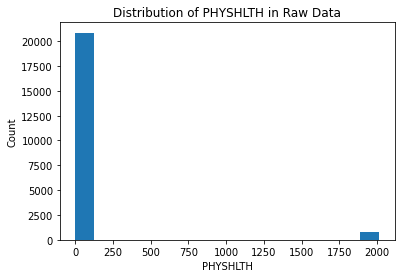

In [263]:
fig, ax = plt.subplots()
ax.hist(data['yr_renovated'], bins="auto")
ax.set_xlabel("PHYSHLTH")
ax.set_ylabel("Count")
ax.set_title("Distribution of PHYSHLTH in Raw Data");

# how home renovations might increase the estimated value of their homes, and by what amount.

In [281]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'propertyTaxPerYear', 'livingAreaRatio',
       'houseAge', 'pricePerSqft', 'year_sold'],
      dtype='object')

# how home rebuilt might increase the estimated value of their homes, and by what amount.

In [290]:
train = data[data['yr_built'] == data['year_sold']]
test = data[data['yr_built'] != data['year_sold']]

X_train = train.drop(["price", "propertyTaxPerYear","pricePerSqft"], axis=1)
y_train = train["price"]

X_test = test.drop(["price", "propertyTaxPerYear","pricePerSqft"], axis=1)
y_test = test["price"]

X_train

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,livingAreaRatio,houseAge,year_sold
42,7203220400,2014-07-07,5,2.75,3595,5639,2.0,NO,NONE,Average,...,3595,?,2014,0.0,98053,3625,5639,0.637524,8,2014
63,9528102996,2014-12-07,3,1.75,1540,1044,3.0,NO,NONE,Average,...,1540,0.0,2014,0.0,98115,1580,3090,1.475096,8,2014
133,8929000270,2014-05-12,3,2.50,2010,2287,2.0,NO,NONE,Average,...,1390,620.0,2014,0.0,98029,1690,1662,0.878881,8,2014
139,2767603505,2014-05-07,3,2.25,1170,1249,3.0,NO,NONE,Average,...,1170,0.0,2014,0.0,98107,1350,1310,0.936749,8,2014
211,1025049114,2014-07-17,3,2.25,1270,1566,2.0,NO,NONE,Average,...,1060,210.0,2014,0.0,98105,1160,1327,0.810983,8,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,4140940150,2014-10-02,4,2.75,2770,3852,2.0,NO,NONE,Average,...,2770,0.0,2014,0.0,98178,1810,5641,0.719107,8,2014
21580,7502800100,2014-08-13,5,2.75,3600,9437,2.0,NO,NONE,Average,...,3600,0.0,2014,0.0,98059,3550,9421,0.381477,8,2014
21582,8956200760,2014-10-13,4,2.50,3118,7866,2.0,NO,AVERAGE,Average,...,3118,0.0,2014,0.0,98001,2673,6500,0.396390,8,2014
21586,844000965,2014-06-26,3,1.75,1500,11968,1.0,NO,NONE,Average,...,1500,0.0,2014,0.0,98010,1320,11303,0.125334,8,2014


In [291]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 42 to 21589
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               430 non-null    int64         
 1   date             430 non-null    datetime64[ns]
 2   bedrooms         430 non-null    int64         
 3   bathrooms        430 non-null    float64       
 4   sqft_living      430 non-null    int64         
 5   sqft_lot         430 non-null    int64         
 6   floors           430 non-null    float64       
 7   waterfront       430 non-null    object        
 8   view             430 non-null    object        
 9   condition        430 non-null    object        
 10  grade            430 non-null    object        
 11  sqft_above       430 non-null    int64         
 12  sqft_basement    430 non-null    object        
 13  yr_built         430 non-null    int64         
 14  yr_renovated     430 non-null    float6

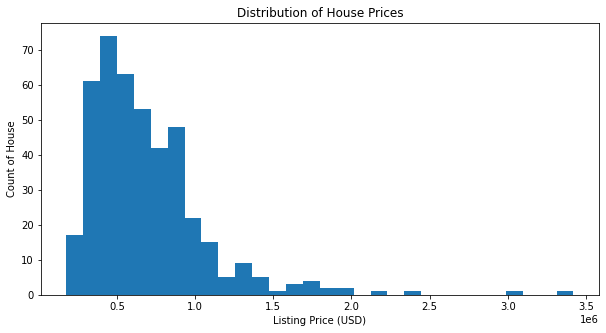

In [293]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(y_train, bins="auto")

ax.set_xlabel("Listing Price (USD)")
ax.set_ylabel("Count of House")
ax.set_title("Distribution of House Prices");

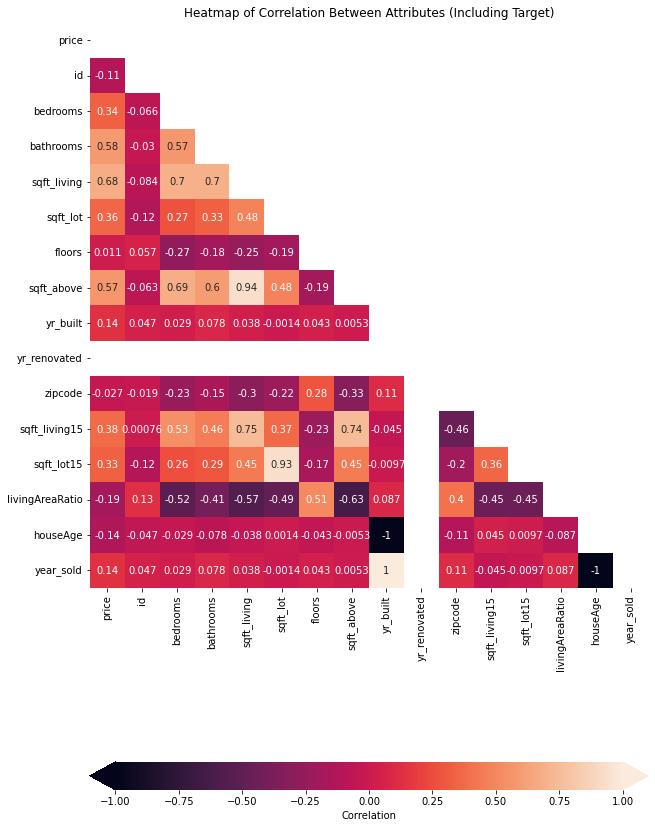

In [296]:


import seaborn as sns
import numpy as np

# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = pd.concat([y_train, X_train], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(10, 16))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [297]:
most_correlated_feature = "sqft_living"

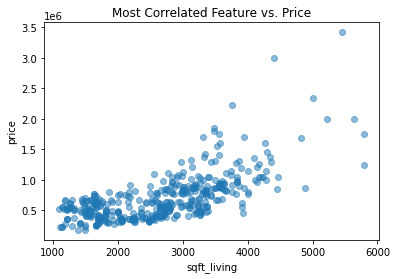

In [298]:
# Run this cell without changes
fig, ax = plt.subplots()

ax.scatter(X_train[most_correlated_feature], y_train, alpha=0.5)
ax.set_xlabel(most_correlated_feature)
ax.set_ylabel("price")
ax.set_title("Most Correlated Feature vs. Price");

In [ ]:

baseline_model = LinearRegression()

In [299]:


splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train[[most_correlated_feature]],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.4562266297374591
Validation score: 0.45618091926457777


In [300]:
X_train_numeric = X_train.select_dtypes("number").copy()

X_train_numeric

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,livingAreaRatio,houseAge,year_sold
42,7203220400,5,2.75,3595,5639,2.0,3595,2014,0.0,98053,3625,5639,0.637524,8,2014
63,9528102996,3,1.75,1540,1044,3.0,1540,2014,0.0,98115,1580,3090,1.475096,8,2014
133,8929000270,3,2.50,2010,2287,2.0,1390,2014,0.0,98029,1690,1662,0.878881,8,2014
139,2767603505,3,2.25,1170,1249,3.0,1170,2014,0.0,98107,1350,1310,0.936749,8,2014
211,1025049114,3,2.25,1270,1566,2.0,1060,2014,0.0,98105,1160,1327,0.810983,8,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,4140940150,4,2.75,2770,3852,2.0,2770,2014,0.0,98178,1810,5641,0.719107,8,2014
21580,7502800100,5,2.75,3600,9437,2.0,3600,2014,0.0,98059,3550,9421,0.381477,8,2014
21582,8956200760,4,2.50,3118,7866,2.0,3118,2014,0.0,98001,2673,6500,0.396390,8,2014
21586,844000965,3,1.75,1500,11968,1.0,1500,2014,0.0,98010,1320,11303,0.125334,8,2014


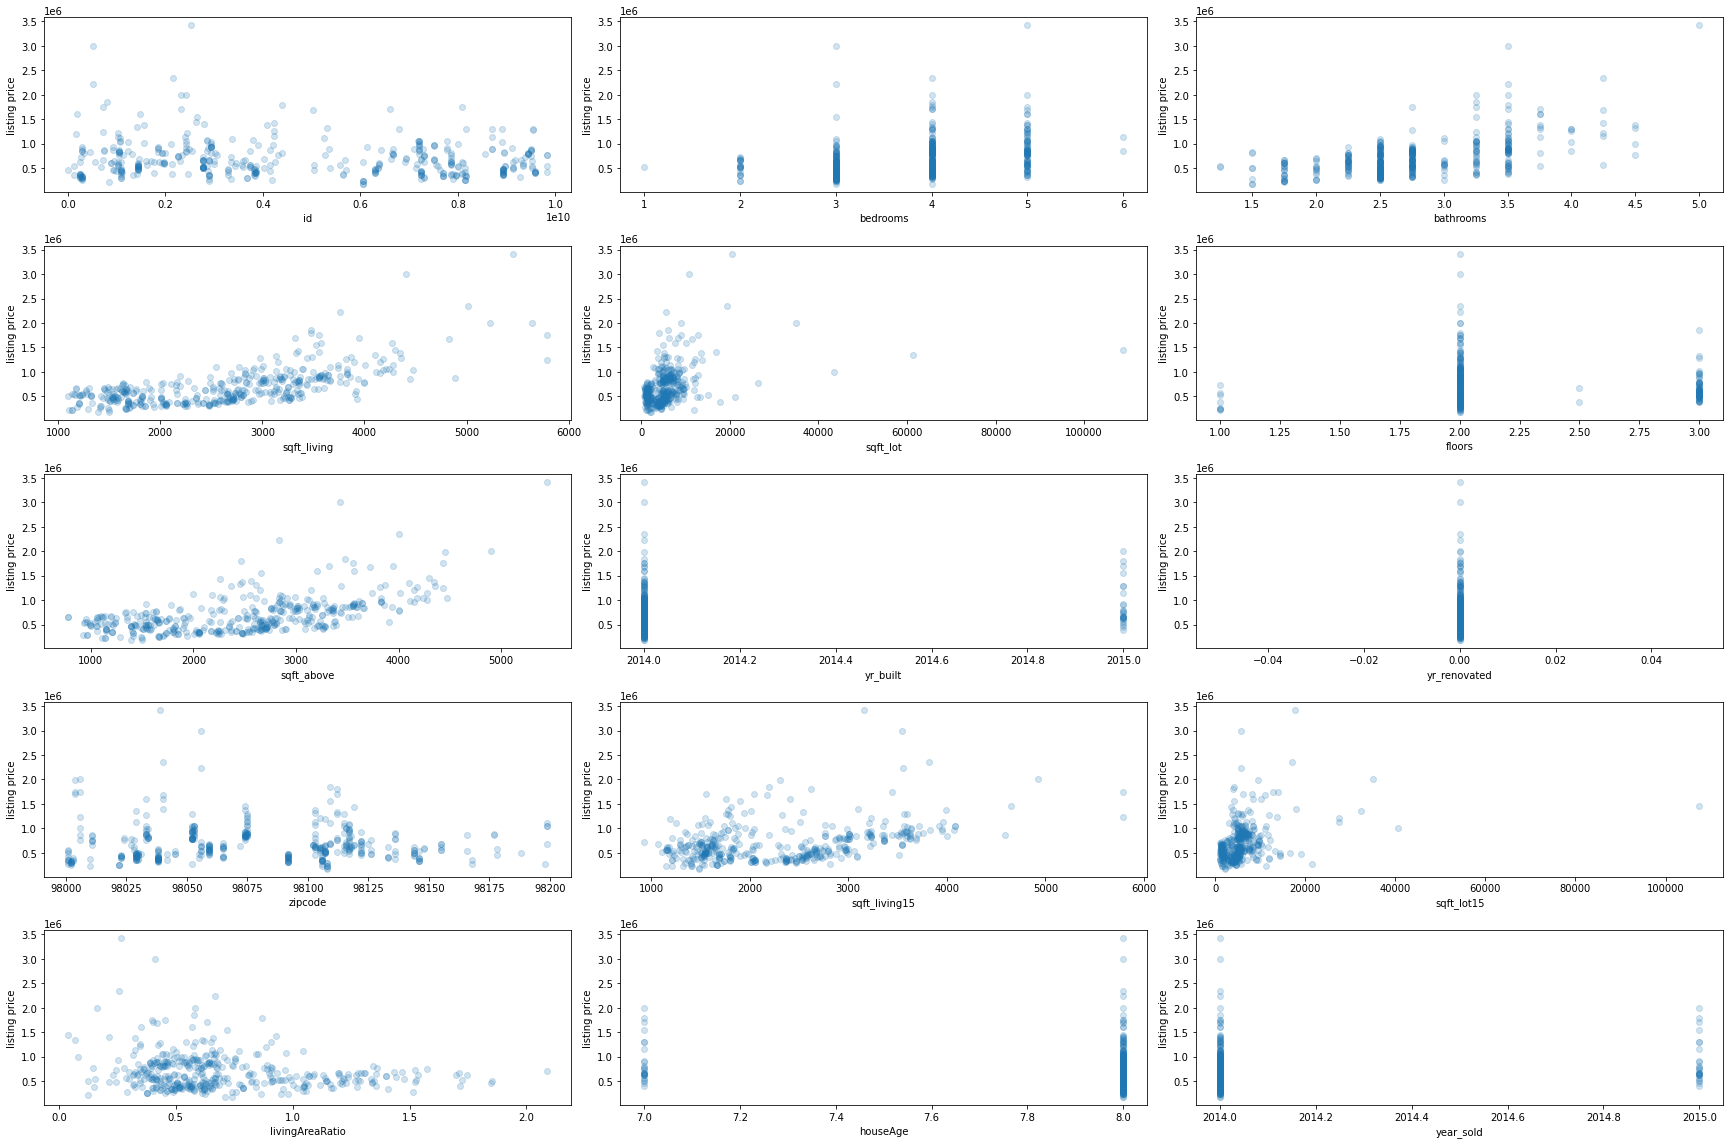

In [305]:
scatterplot_data = X_train_numeric

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(24, 16))
fig.set_tight_layout(True)

for index, col in enumerate(scatterplot_data.columns):
    ax = axes[index//3][index%3]
    ax.scatter(X_train_numeric[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("listing price")

In [355]:
data['view'].value_counts()

NONE         19485
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

## follow leature

In [467]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'propertyTaxPerYear', 'livingAreaRatio',
       'year_sold', 'houseAge', 'pricePerSqft'],
      dtype='object')

In [468]:
df = data.drop(columns= ['id', 'date', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'propertyTaxPerYear', 'pricePerSqft', 'zipcode','year_sold','yr_built','yr_renovated' ])

In [469]:
df = df[df['houseAge'] < 1]

In [470]:
df['houseAge'].value_counts()

 0    430
-1     12
Name: houseAge, dtype: int64

In [471]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 42 to 21589
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            442 non-null    float64
 1   bedrooms         442 non-null    int64  
 2   bathrooms        442 non-null    float64
 3   sqft_living      442 non-null    int64  
 4   sqft_lot         442 non-null    int64  
 5   floors           442 non-null    float64
 6   sqft_living15    442 non-null    int64  
 7   sqft_lot15       442 non-null    int64  
 8   livingAreaRatio  442 non-null    float64
 9   houseAge         442 non-null    int64  
dtypes: float64(4), int64(6)
memory usage: 38.0 KB


In [472]:
X = df.drop(columns = ['price'])
Y = df['price']

In [473]:
X

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_living15,sqft_lot15,livingAreaRatio,houseAge
42,5,2.75,3595,5639,2.0,3625,5639,0.637524,0
63,3,1.75,1540,1044,3.0,1580,3090,1.475096,0
133,3,2.50,2010,2287,2.0,1690,1662,0.878881,0
139,3,2.25,1170,1249,3.0,1350,1310,0.936749,0
211,3,2.25,1270,1566,2.0,1160,1327,0.810983,0
...,...,...,...,...,...,...,...,...,...
21575,4,2.75,2770,3852,2.0,1810,5641,0.719107,0
21580,5,2.75,3600,9437,2.0,3550,9421,0.381477,0
21582,4,2.50,3118,7866,2.0,2673,6500,0.396390,0
21586,3,1.75,1500,11968,1.0,1320,11303,0.125334,0


In [474]:
X.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_living15,sqft_lot15,livingAreaRatio,houseAge
bedrooms,1.000000,0.579423,0.707657,0.276501,-0.248584,0.534356,0.264687,-0.500899,0.096395
bathrooms,0.579423,1.000000,0.711370,0.327647,-0.166322,0.462372,0.292468,-0.374677,0.087670
sqft_living,0.707657,0.711370,1.000000,0.474060,-0.236272,0.743208,0.441135,-0.545118,0.078584
sqft_lot,0.276501,0.327647,0.474060,1.000000,-0.194044,0.372969,0.929182,-0.489977,0.039175
floors,-0.248584,-0.166322,-0.236272,-0.194044,1.000000,-0.223660,-0.171912,0.521961,-0.068353
sqft_living15,0.534356,0.462372,0.743208,0.372969,-0.223660,1.000000,0.357388,-0.438589,0.103552
sqft_lot15,0.264687,0.292468,0.441135,0.929182,-0.171912,0.357388,1.000000,-0.448043,0.005787
livingAreaRatio,-0.500899,-0.374677,-0.545118,-0.489977,0.521961,-0.438589,-0.448043,1.000000,-0.070055
houseAge,0.096395,0.087670,0.078584,0.039175,-0.068353,0.103552,0.005787,-0.070055,1.000000


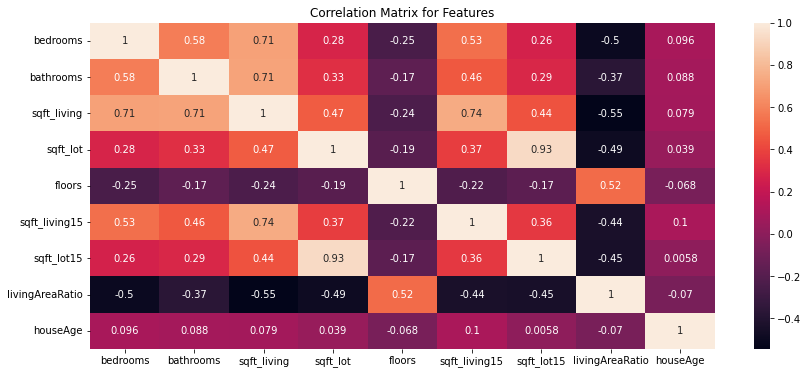

In [475]:
plt.figure(figsize = (14, 6))
sns.heatmap(X.corr(), annot = True)

plt.title('Correlation Matrix for Features')
plt.savefig("corrmat.jpg" , dpi=300)
plt.show()

Highly correlated variables:
bathrooms vs sqft_living
bedrooms vs sqft_living
sqft_lot vs sqft_lot15
sqft_living vs sqft_living15
getting rid of:
bedrooms
bathrooms
sqft_lot15
sqft_living15
houseAge

In [476]:
X = X.drop(columns = ['bathrooms','bedrooms', 'sqft_lot15', 'sqft_living15', 'houseAge'])
X.head()

,sqft_living,sqft_lot,floors,livingAreaRatio
42,3595,5639,2.0,0.637524
63,1540,1044,3.0,1.475096
133,2010,2287,2.0,0.878881
139,1170,1249,3.0,0.936749
211,1270,1566,2.0,0.810983


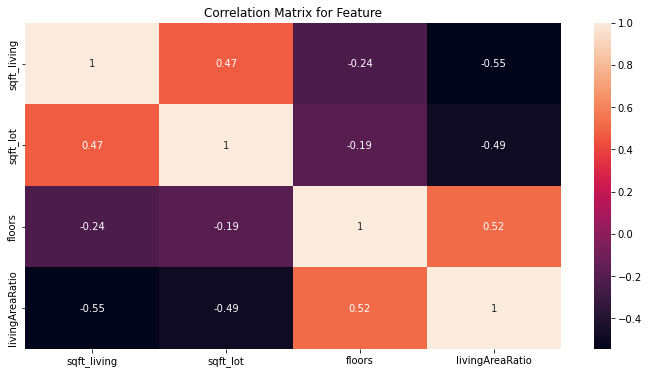

In [478]:
plt.figure(figsize = (12,6))
sns.heatmap(X.corr(), annot = True)

plt.title('Correlation Matrix for Feature')
plt.savefig("corrmat.jpg" , dpi=300)
plt.show()

In [479]:
X_augmented = sm.add_constant(X)
X_augmented

,const,sqft_living,sqft_lot,floors,livingAreaRatio
42,1.0,3595,5639,2.0,0.637524
63,1.0,1540,1044,3.0,1.475096
133,1.0,2010,2287,2.0,0.878881
139,1.0,1170,1249,3.0,0.936749
211,1.0,1270,1566,2.0,0.810983
...,...,...,...,...,...
21575,1.0,2770,3852,2.0,0.719107
21580,1.0,3600,9437,2.0,0.381477
21582,1.0,3118,7866,2.0,0.396390
21586,1.0,1500,11968,1.0,0.125334


In [481]:
results = sm.OLS(Y, X_augmented).fit()

In [482]:
results.params

const             -514478.208961
sqft_living           306.807136
sqft_lot                7.341553
floors              78726.305611
livingAreaRatio    264731.983595
dtype: float64

In [483]:
results.rsquared

0.5066469710587813

In [485]:
results.rsquared_adj

0.5021311538602347

In [486]:
X.describe()

,sqft_living,sqft_lot,floors,livingAreaRatio
count,442.000000,442.000000,442.000000,442.000000
mean,2631.117647,5524.343891,2.132353,0.690264
std,926.377305,6937.332563,0.389800,0.348565
min,710.000000,638.000000,1.000000,0.039498
25%,1760.000000,2214.500000,2.000000,0.450979
50%,2670.000000,4835.000000,2.000000,0.600987
75%,3279.250000,6539.750000,2.000000,0.861017
max,5790.000000,108865.000000,3.000000,2.089762


In [488]:
def standardizer(col):
    col_standardized = (col - col.mean())/col.std()
    return col_standardized

In [489]:
X_standard = X.apply(lambda x : (x-x.mean())/x.std())

In [490]:
X_standard.describe()

,sqft_living,sqft_lot,floors,livingAreaRatio
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,1.165483e-16,2.813235e-17,9.645377e-17,3.496449e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.073796e+00,-7.043549e-01,-2.904958e+00,-1.866986e+00
25%,-9.403486e-01,-4.771061e-01,-3.395406e-01,-6.864860e-01
50%,4.197248e-02,-9.936728e-02,-3.395406e-01,-2.561271e-01
75%,6.996419e-01,1.463684e-01,-3.395406e-01,4.898745e-01
max,3.409931e+00,1.489631e+01,2.225877e+00,4.015026e+00


In [498]:
Y_standard = (Y - Y.mean())/Y.std()

In [499]:
X_standard_aug = sm.add_constant(X_standard)

In [500]:
results_standardized = sm.OLS(Y_standard, X_standard_aug).fit()

In [501]:
weights = results_standardized.params
weights

const             -6.158268e-17
sqft_living        7.561280e-01
sqft_lot           1.354947e-01
floors             8.164015e-02
livingAreaRatio    2.454891e-01
dtype: float64

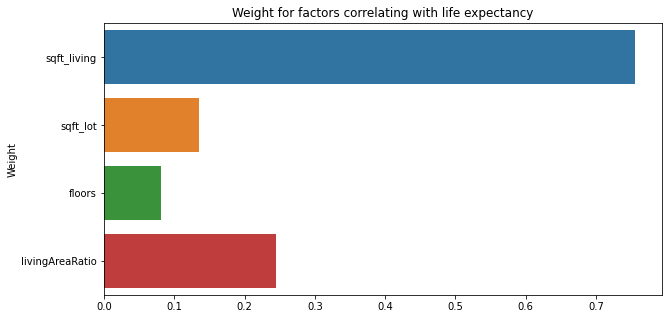

In [502]:
plt.figure(figsize=(10,5))
sns.barplot(y=weights[1::].index, x = weights[1::].values)
plt.title("Weight for factors correlating with life expectancy")
plt.ylabel("Weight")
plt.show()

In [514]:
results_standardized.rsquared

0.5066469710587812

In [515]:
results_standardized.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     112.2
Date:                Tue, 29 Mar 2022   Prob (F-statistic):           1.01e-65
Time:                        23:15:27   Log-Likelihood:                -470.53
No. Observations:                 442   AIC:                             951.1
Df Residuals:                     437   BIC:                             971.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -6.158e-17      0.034  -1.83e-15      1.000      -0.066       0.066
sqft_living         0.7561      0.042     18.075      0.000       0.674       0.838
sqft_lot            0.1355      0.040      3.364      0.001       0.056       0.215
floors              0.0816      0.040      2.063      0.040       0.004       0.159
livingAreaRatio     0.2455      0.048      5.106      0.000       0.151       0.340
==============================================================================
Omnibus:                      247.243   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3004.457
Skew:                           2.139   Prob(JB):                         0.00
Kurtosis:                      15.035   Cond. No.                         2.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [517]:
lr = LinearRegression()
lr

LinearRegression()

In [519]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)


In [521]:
print(len(X_train), len(Y_train))

309 309


In [522]:
lr.fit(X_train,Y_train)

LinearRegression()

In [523]:
lr.coef_

array([2.95323190e+02, 7.18827612e+00, 8.12824347e+04, 2.46540152e+05])

In [524]:
lr.intercept_

-478759.9615982232

In [525]:
X.columns

Index(['sqft_living', 'sqft_lot', 'floors', 'livingAreaRatio'], dtype='object')

In [526]:
lr.score(X_train,Y_train)

0.5052457211412851

In [527]:
Y_pred = lr.predict(X_test)
Y_pred[0:10]

array([568589.82135346, 513913.81067854, 660416.96420225, 355077.76277176,
       749004.247334  , 999253.98834985, 432287.04226384, 596029.62635537,
       846194.13383334, 694719.9946154 ])

In [529]:
MAE = mean_absolute_error(Y_pred, Y_test)
MAE

174371.6114958206

In [530]:
RMSE = np.sqrt(mean_squared_error(Y_pred,Y_test))
RMSE

276347.74154946837

In [532]:
%%capture price_test
fig, ax = plt.subplots()
Y_test.hist(bins='auto', ax=ax)
ax.set_xlabel("price")
ax.set_ylabel("Counts")
ax.set_title('price expectancy: test distribution')
plt.show()

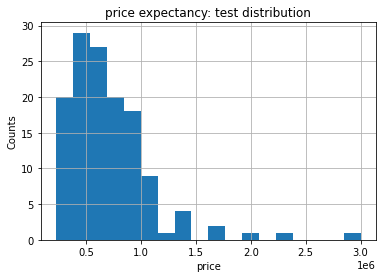

In [534]:
price_test()

In [535]:
examp_idx = 10
single_examp = X_test.iloc[examp_idx].values
X_test.iloc[examp_idx]

sqft_living        1760.000000
sqft_lot           5390.000000
floors                1.000000
livingAreaRatio       0.326531
Name: 20270, dtype: float64

In [536]:
lr.predict(single_examp.reshape(1,-1))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([241539.00246263])

In [537]:
Y_test.iloc[examp_idx]

382495.0